In [1]:
#Base Imports
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Pre Processing Imports
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer , SnowballStemmer
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()
stemmer = SnowballStemmer("english")
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#Model Building Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN ,LSTM, Embedding, Dropout, GRU , Bidirectional #Activation, Flatten, Input, GRU , Bidirectional#  concatenate, #GlobalMaxPooling1D, MaxPooling1D
#Model Evaluation imports
from sklearn import metrics
from sklearn.metrics import (classification_report,confusion_matrix , 
                             precision_recall_curve ,precision_score,recall_score , accuracy_score,SCORERS)


 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('emotions_preprocessed.csv')

In [3]:
def stemming(text):
    text = text.split()
    text = [stemmer.stem(y) for y in text]
    
    return " ".join(text)


def lemmatization(text):
     text = text.split()
     text=[lemmatizer.lemmatize(y) for y in text]
    
     return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def remove_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
            
def clean_stopwords_removed_lemma(df):
    
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : remove_numbers(text))
    df.text=df.text.apply(lambda text : remove_punctuations(text))
    df.text=df.text.apply(lambda text : remove_urls(text))
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df

def clean_stopwords_removed_stemming(df):
    
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : remove_numbers(text))
    df.text=df.text.apply(lambda text : remove_punctuations(text))
    df.text=df.text.apply(lambda text : remove_urls(text))
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : stemming(text))
    return df

def clean_stopwords_present_stemming(df):
    
    df.text=df.text.apply(lambda text : remove_numbers(text))
    df.text=df.text.apply(lambda text : remove_punctuations(text))
    df.text=df.text.apply(lambda text : remove_urls(text))
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : stemming(text))
    return df

def clean_stopwords_present_lemma(df):
    df.text=df.text.apply(lambda text : remove_numbers(text))
    df.text=df.text.apply(lambda text : remove_punctuations(text))
    df.text=df.text.apply(lambda text : remove_urls(text))
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df



  

In [4]:
df_clean_stopwords_removed_stemming = clean_stopwords_removed_stemming(df)
df_clean_stopwords_present_stemming =  clean_stopwords_present_stemming(df)
df_clean_stopwords_present_lemma = clean_stopwords_present_lemma(df)

## Stemming With Stop Words Removed

In [5]:
X= df_clean_stopwords_removed_stemming.text
y= df_clean_stopwords_removed_stemming.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.1, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.5,random_state=70)

In [6]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
max_len = max([len(t) for t in X_train])
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')
vocabSize = len(tokenizer.index_word) + 1

#Text Representation Using Glove Embedding 
path_to_glove_file = 'glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

#define early stopping to control overfitting
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Found 23858 word vectors.
Converted 5468 words (13865 misses)


In [7]:
gru_model = Sequential()
gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(14, activation='softmax'))
gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 526, 300)          5800200   
                                                                 
 gru (GRU)                   (None, 526, 64)           70272     
                                                                 
 dropout (Dropout)           (None, 526, 64)           0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 14)                462       
                                                                 
Total params: 5,880,342
Trainable params: 80,142
Non-tra

In [8]:
gru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [9]:
# Fit model
history_gru=gru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
190/190 [==============================] - 21s 61ms/step - loss: 2.2498 - accuracy: 0.3364 - val_loss: 1.9976 - val_accuracy: 0.4100
Epoch 2/30
190/190 [==============================] - 10s 55ms/step - loss: 2.0251 - accuracy: 0.4078 - val_loss: 1.8992 - val_accuracy: 0.4315
Epoch 3/30
190/190 [==============================] - 10s 55ms/step - loss: 1.9526 - accuracy: 0.4260 - val_loss: 1.8548 - val_accuracy: 0.4426
Epoch 4/30
190/190 [==============================] - 11s 55ms/step - loss: 1.9143 - accuracy: 0.4344 - val_loss: 1.8205 - val_accuracy: 0.4500
Epoch 5/30
190/190 [==============================] - 12s 63ms/step - loss: 1.8822 - accuracy: 0.4415 - val_loss: 1.8025 - val_accuracy: 0.4563
Epoch 6/30
190/190 [==============================] - 11s 57ms/step - loss: 1.8621 - accuracy: 0.4467 - val_loss: 1.7843 - val_accuracy: 0.4607
Epoch 7/30
190/190 [==============================] - 11s 56ms/step - loss: 1.8450 - accuracy: 0.4497 - val_loss: 1.7732 - val_accuracy:

In [10]:
gru_y_pred = gru_model.predict(X_test)
gru_y_pred_labels = np.argmax(gru_y_pred, axis=1)
gru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(gru_y_test_labels, gru_y_pred_labels))

85/85 [==============================] - 2s 17ms/step
              precision    recall  f1-score   support

           0       0.41      0.86      0.56       763
           1       0.43      0.18      0.26       195
           2       0.31      0.10      0.15        90
           3       0.38      0.25      0.30        53
           4       0.24      0.05      0.08       168
           5       0.55      0.47      0.51       278
           6       0.55      0.23      0.32        52
           7       0.78      0.83      0.80       134
           8       0.44      0.22      0.30       206
           9       0.27      0.03      0.06        91
          10       0.54      0.39      0.45       144
          11       0.46      0.25      0.32       252
          12       0.34      0.10      0.16       136
          13       0.53      0.54      0.53       138

    accuracy                           0.46      2700
   macro avg       0.45      0.32      0.34      2700
weighted avg       0.45   

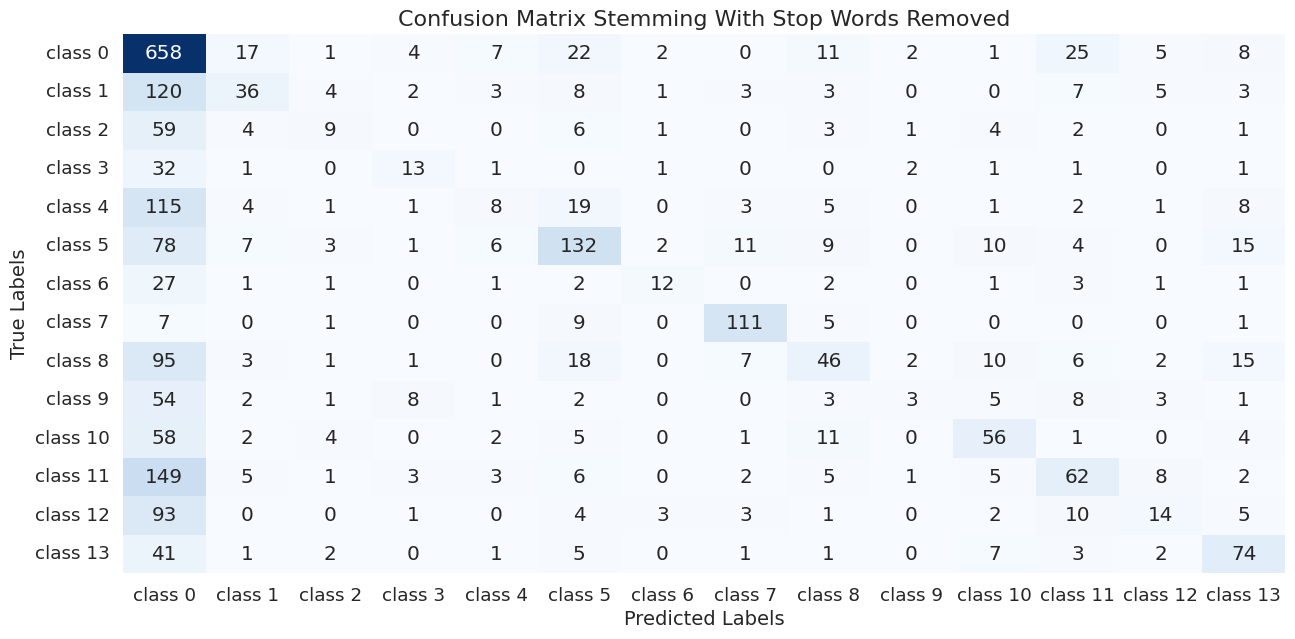

In [11]:
conf_mat_gru = confusion_matrix(gru_y_test_labels, gru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_gru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix Stemming With Stop Words Removed', fontsize=16)
plt.show()


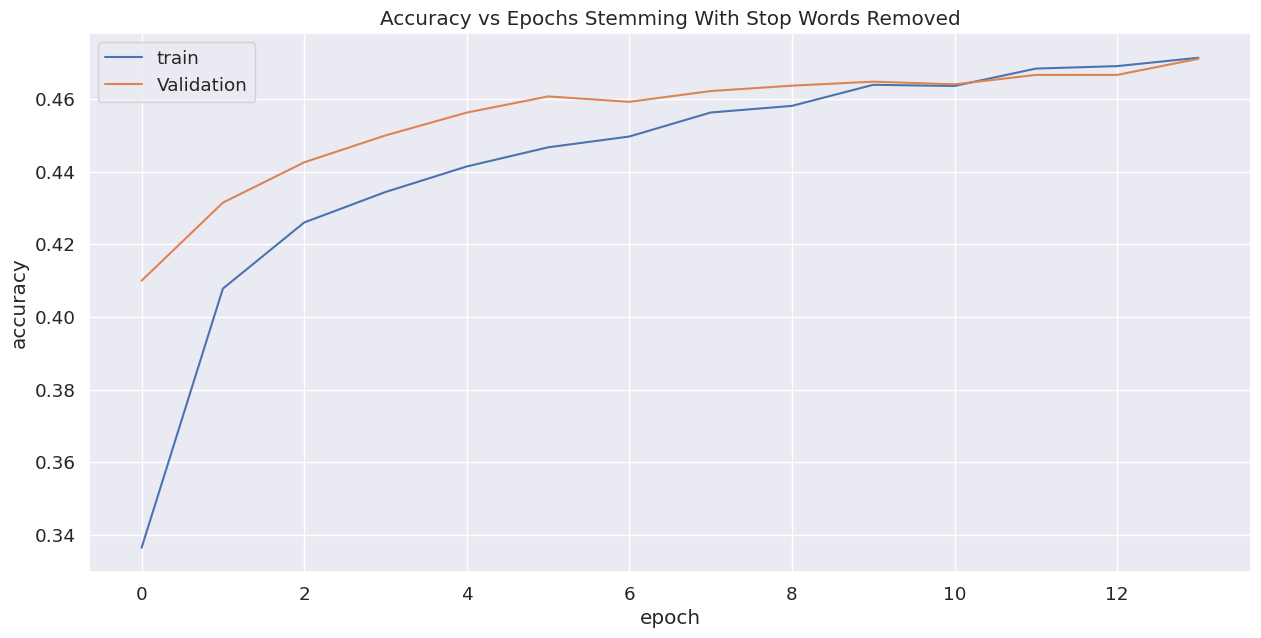

In [12]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Accuracy vs Epochs Stemming With Stop Words Removed')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

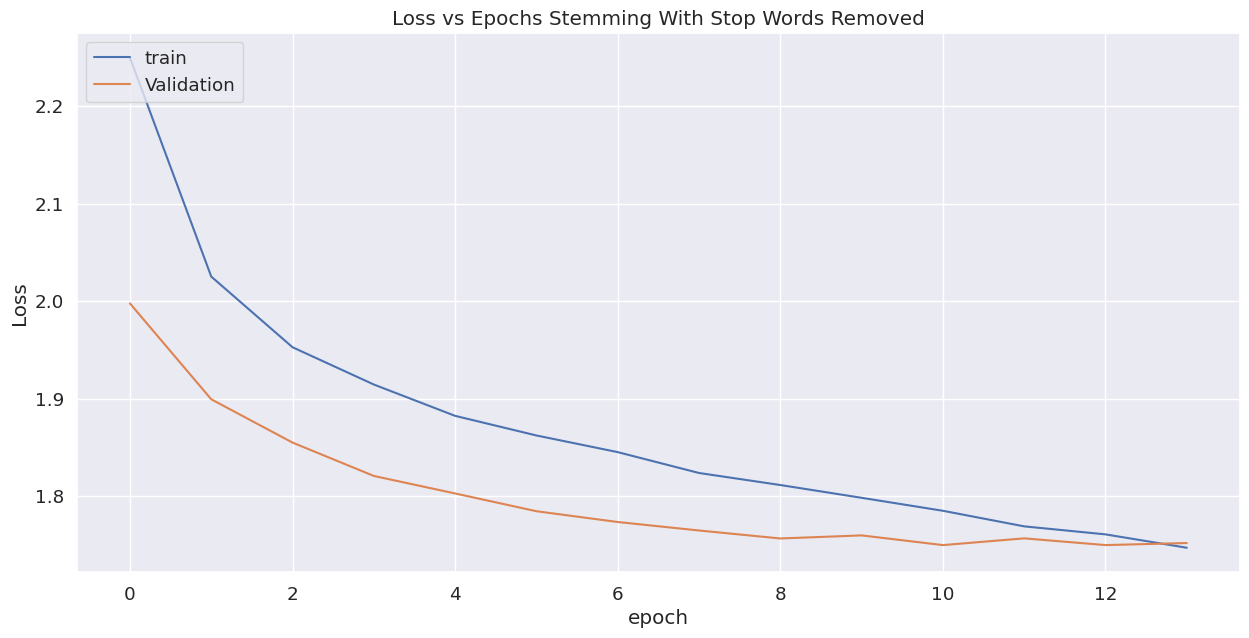

In [13]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Loss vs Epochs Stemming With Stop Words Removed')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Stemming With Stop Words Present

In [14]:
X= df_clean_stopwords_present_stemming.text
y= df_clean_stopwords_present_stemming.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.1, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.5,random_state=70)

In [15]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
max_len = max([len(t) for t in X_train])
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')
vocabSize = len(tokenizer.index_word) + 1

#Text Representation Using Glove Embedding 
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

#define early stopping to control overfitting
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Found 41286 word vectors.
Converted 7014 words (12319 misses)


In [16]:
gru_model = Sequential()
gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(14, activation='softmax'))
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 526, 300)          5800200   
                                                                 
 gru_2 (GRU)                 (None, 526, 64)           70272     
                                                                 
 dropout_2 (Dropout)         (None, 526, 64)           0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 14)                462       
                                                                 
Total params: 5,880,342
Trainable params: 80,142
Non-t

In [17]:
gru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [18]:
# Fit model
history_gru=gru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
190/190 [==============================] - 16s 63ms/step - loss: 2.2322 - accuracy: 0.3420 - val_loss: 1.9711 - val_accuracy: 0.4252
Epoch 2/30
190/190 [==============================] - 11s 59ms/step - loss: 2.0015 - accuracy: 0.4158 - val_loss: 1.8875 - val_accuracy: 0.4437
Epoch 3/30
190/190 [==============================] - 11s 59ms/step - loss: 1.9343 - accuracy: 0.4330 - val_loss: 1.8409 - val_accuracy: 0.4533
Epoch 4/30
190/190 [==============================] - 11s 59ms/step - loss: 1.8959 - accuracy: 0.4440 - val_loss: 1.8103 - val_accuracy: 0.4611
Epoch 5/30
190/190 [==============================] - 11s 58ms/step - loss: 1.8645 - accuracy: 0.4503 - val_loss: 1.7867 - val_accuracy: 0.4611
Epoch 6/30
190/190 [==============================] - 11s 58ms/step - loss: 1.8420 - accuracy: 0.4554 - val_loss: 1.7674 - val_accuracy: 0.4685
Epoch 7/30
190/190 [==============================] - 11s 58ms/step - loss: 1.8225 - accuracy: 0.4596 - val_loss: 1.7566 - val_accuracy:

In [19]:
gru_y_pred = gru_model.predict(X_test)
gru_y_pred_labels = np.argmax(gru_y_pred, axis=1)
gru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(gru_y_test_labels, gru_y_pred_labels))

85/85 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.42      0.82      0.56       763
           1       0.43      0.22      0.29       195
           2       0.31      0.12      0.17        90
           3       0.39      0.26      0.31        53
           4       0.23      0.04      0.07       168
           5       0.52      0.47      0.50       278
           6       0.59      0.25      0.35        52
           7       0.77      0.83      0.80       134
           8       0.47      0.18      0.26       206
           9       0.33      0.12      0.18        91
          10       0.50      0.41      0.45       144
          11       0.50      0.36      0.42       252
          12       0.33      0.15      0.20       136
          13       0.53      0.53      0.53       138

    accuracy                           0.46      2700
   macro avg       0.45      0.34      0.36      2700
weighted avg       0.45   

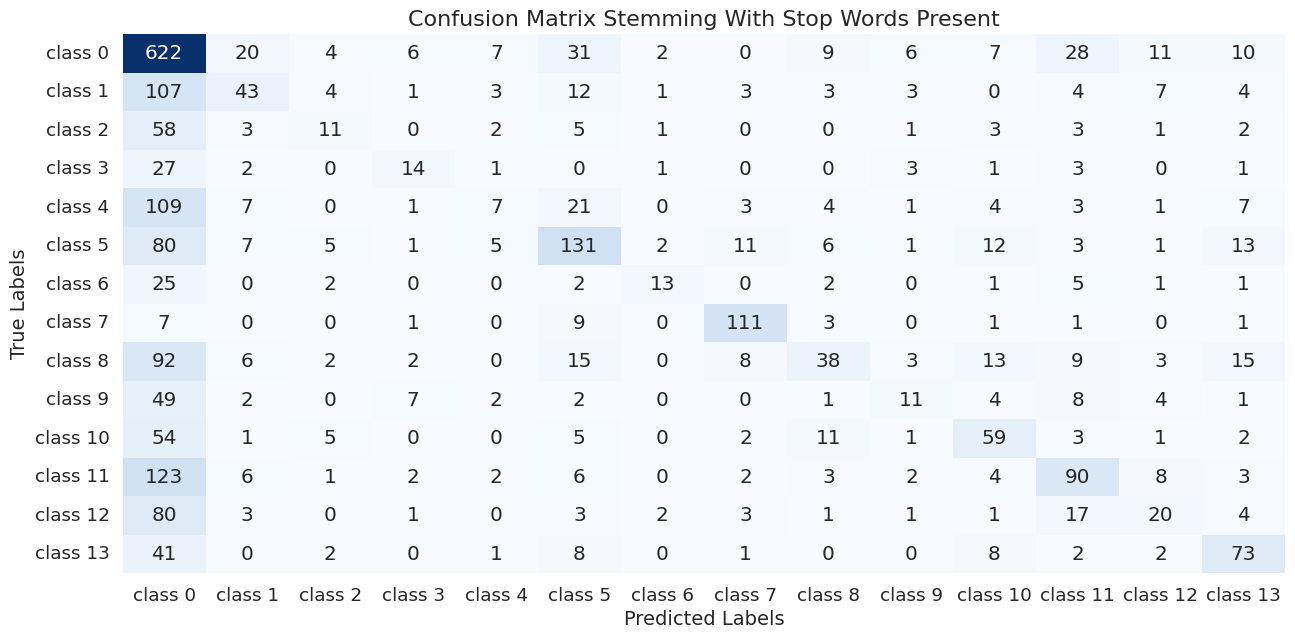

In [20]:
conf_mat_gru = confusion_matrix(gru_y_test_labels, gru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_gru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix Stemming With Stop Words Present', fontsize=16)
plt.show()

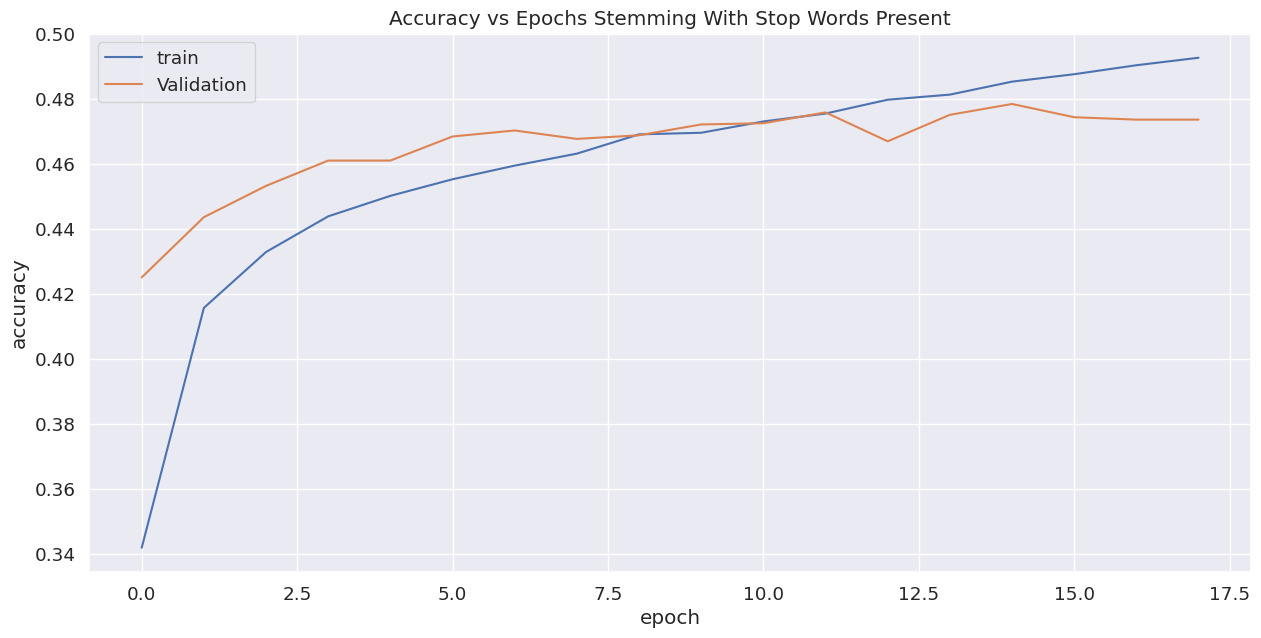

In [21]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Accuracy vs Epochs Stemming With Stop Words Present')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

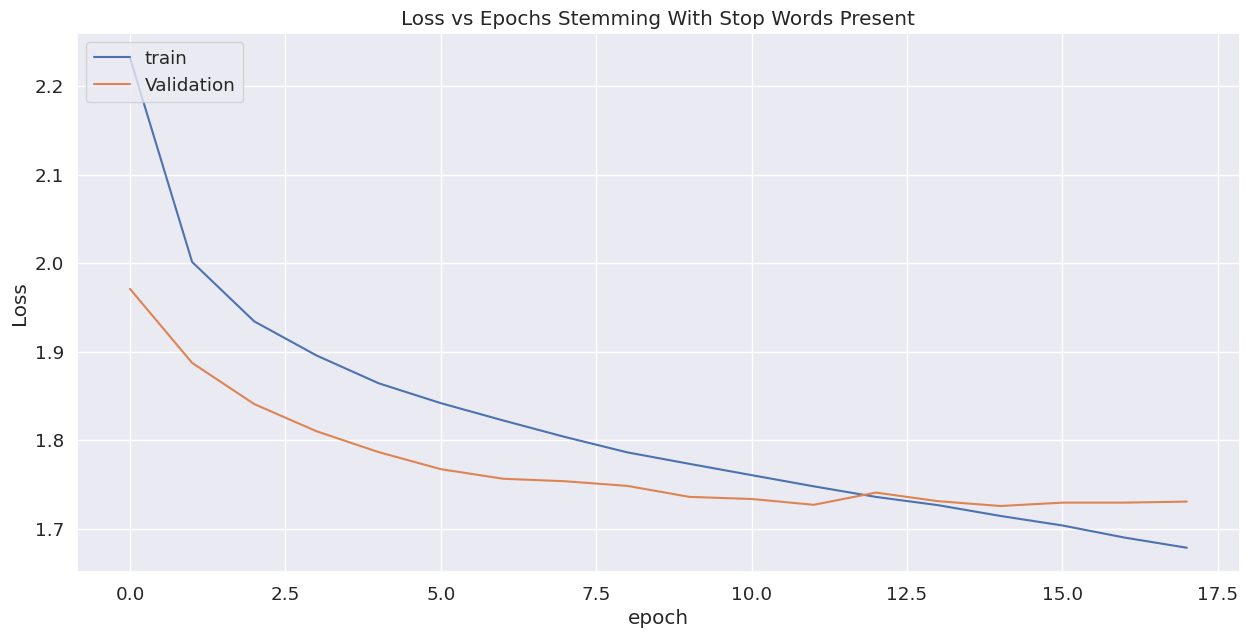

In [22]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Loss vs Epochs Stemming With Stop Words Present')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Lemmatization With Stop Words Present

In [23]:
X= df_clean_stopwords_present_lemma.text
y= df_clean_stopwords_present_lemma.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.1, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.5,random_state=70)

In [24]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
max_len = max([len(t) for t in X_train])
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')
vocabSize = len(tokenizer.index_word) + 1

#Text Representation Using Glove Embedding 
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

#define early stopping to control overfitting
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Found 59131 word vectors.
Converted 7936 words (11397 misses)


In [25]:
gru_model = Sequential()
gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(14, activation='softmax'))
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 526, 300)          5800200   
                                                                 
 gru_4 (GRU)                 (None, 526, 64)           70272     
                                                                 
 dropout_4 (Dropout)         (None, 526, 64)           0         
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 14)                462       
                                                                 
Total params: 5,880,342
Trainable params: 80,142
Non-t

In [26]:
gru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [27]:
# Fit model
history_gru=gru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
190/190 [==============================] - 16s 61ms/step - loss: 2.2397 - accuracy: 0.3360 - val_loss: 1.9760 - val_accuracy: 0.4070
Epoch 2/30
190/190 [==============================] - 11s 58ms/step - loss: 2.0059 - accuracy: 0.4109 - val_loss: 1.8751 - val_accuracy: 0.4456
Epoch 3/30
190/190 [==============================] - 11s 58ms/step - loss: 1.9260 - accuracy: 0.4340 - val_loss: 1.8204 - val_accuracy: 0.4559
Epoch 4/30
190/190 [==============================] - 11s 58ms/step - loss: 1.8873 - accuracy: 0.4434 - val_loss: 1.7921 - val_accuracy: 0.4581
Epoch 5/30
190/190 [==============================] - 11s 57ms/step - loss: 1.8543 - accuracy: 0.4504 - val_loss: 1.7654 - val_accuracy: 0.4667
Epoch 6/30
190/190 [==============================] - 11s 58ms/step - loss: 1.8298 - accuracy: 0.4590 - val_loss: 1.7473 - val_accuracy: 0.4689
Epoch 7/30
190/190 [==============================] - 11s 57ms/step - loss: 1.8123 - accuracy: 0.4656 - val_loss: 1.7426 - val_accuracy:

In [28]:
gru_y_pred = gru_model.predict(X_test)
gru_y_pred_labels = np.argmax(gru_y_pred, axis=1)
gru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(gru_y_test_labels, gru_y_pred_labels))

85/85 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.43      0.82      0.57       763
           1       0.49      0.19      0.28       195
           2       0.28      0.12      0.17        90
           3       0.43      0.36      0.39        53
           4       0.41      0.15      0.22       168
           5       0.54      0.46      0.50       278
           6       0.57      0.23      0.33        52
           7       0.75      0.84      0.79       134
           8       0.48      0.21      0.30       206
           9       0.25      0.07      0.10        91
          10       0.52      0.35      0.42       144
          11       0.52      0.40      0.45       252
          12       0.37      0.13      0.19       136
          13       0.52      0.54      0.53       138

    accuracy                           0.47      2700
   macro avg       0.47      0.35      0.37      2700
weighted avg       0.47   

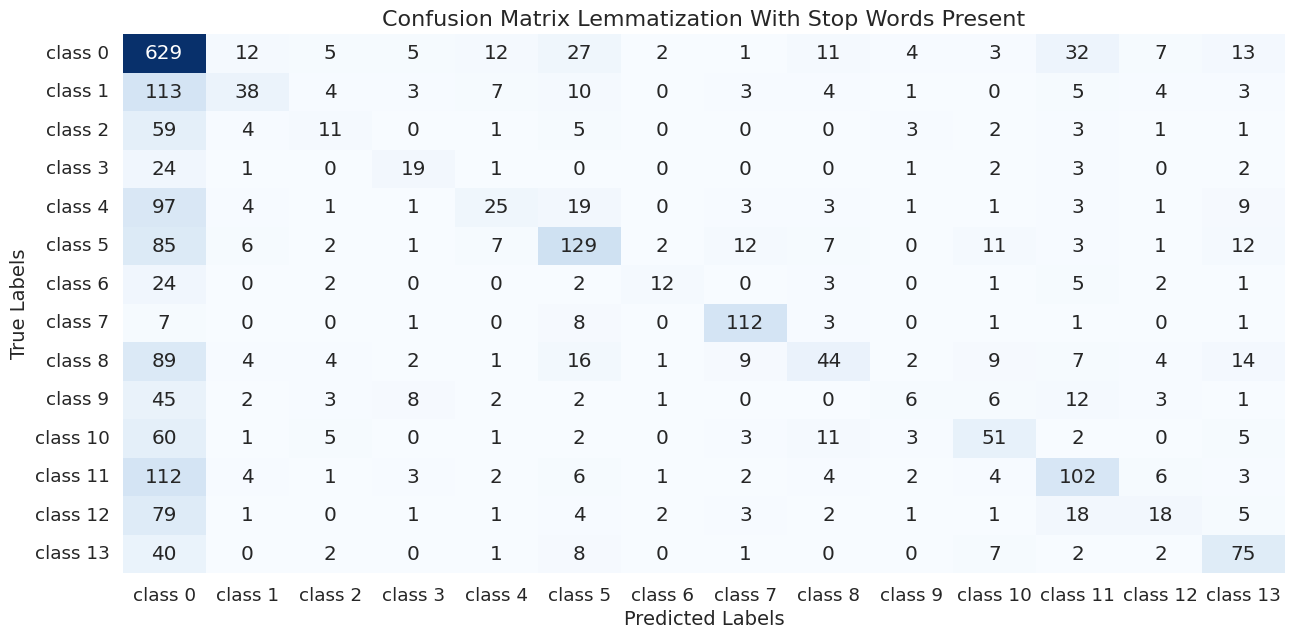

In [29]:
conf_mat_gru = confusion_matrix(gru_y_test_labels, gru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_gru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix Lemmatization With Stop Words Present', fontsize=16)
plt.show()


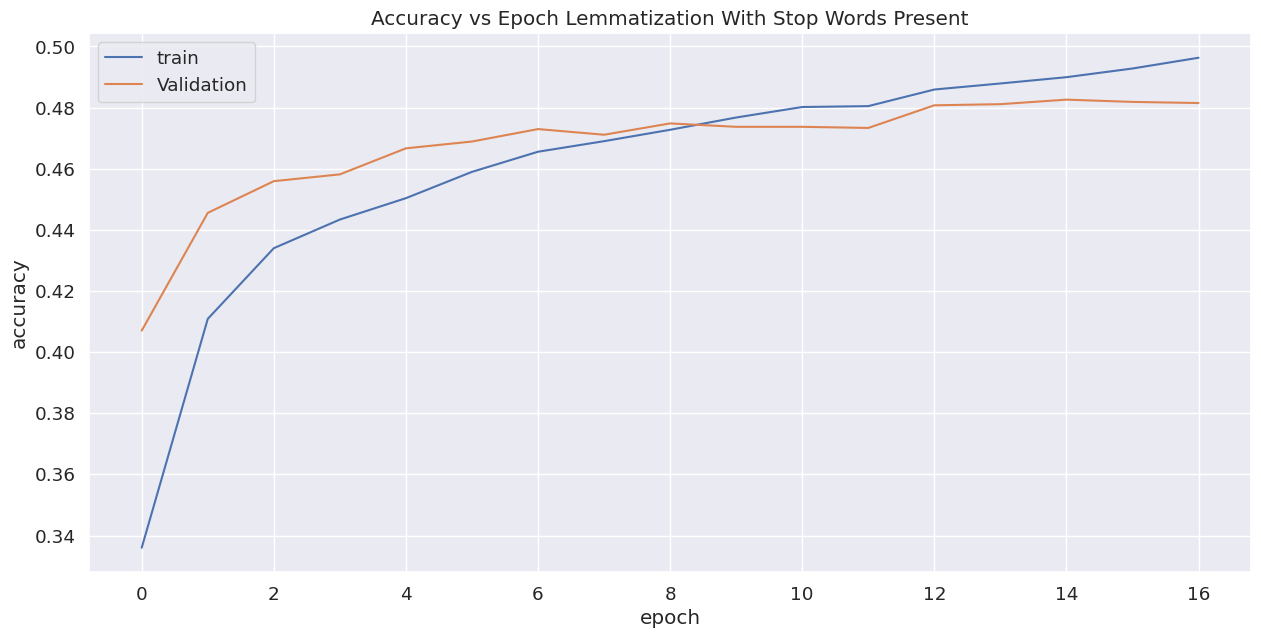

In [31]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Accuracy vs Epoch Lemmatization With Stop Words Present')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

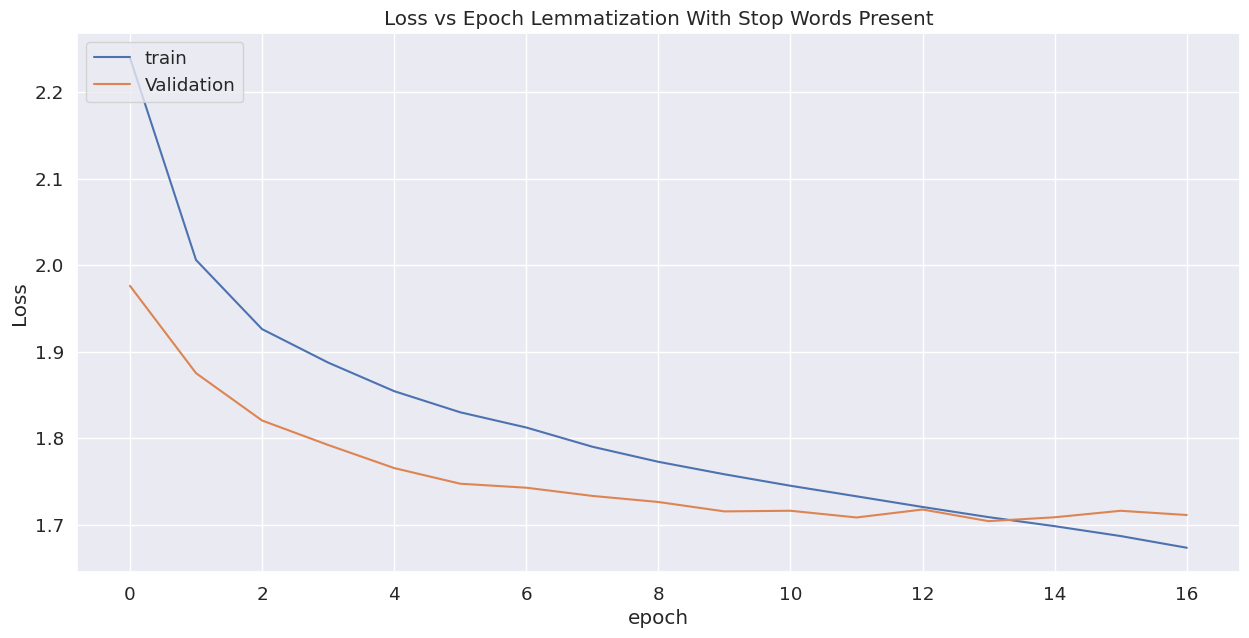

In [32]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Loss vs Epoch Lemmatization With Stop Words Present')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()